In [1]:
import pandas as pd
import numpy as np
import time

## global variables

In [2]:
gamma = 0.1
landa = 1
error_weight = 0.5

## prepare data

In [3]:
data = pd.read_csv('pima-indians-diabetes.csv')

In [4]:
data = np.array(data.get_values(),dtype = np.float)

In [26]:
data /= np.max(data,axis=0)

In [27]:
x = data[:,:-1]

In [28]:
y = data[:,-1]

In [29]:
for i in range(len(y)):
    if y[i] ==0:
        y[i] = -1

### train test split (60% train, 40% test)

In [5]:
from sklearn.model_selection import train_test_split

In [31]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=42)

## optimization part

In [6]:
import pulp

In [7]:
def LpMinimizeClassification(x_train,y_train, problem_name = 'classification prob'):
    prob = pulp.LpProblem(problem_name, pulp.LpMinimize)
    decision_variables = []
    v_variable = []
    # define variables
    for i in range(len(x_train)+1):
        variable = str('t' + str(i))
        variable = pulp.LpVariable(str(variable))
        decision_variables.append(variable)
        variable = str('v' + str(i))
        variable = pulp.LpVariable(str(variable))
        decision_variables.append(variable)
        v_variable.append(variable)
        variable = str('e' + str(i))
        variable = pulp.LpVariable(str(variable)) 
        if i < len(x_train):
            decision_variables.append(variable)
#     print ("Total number of decision_variables: " + str(len(decision_variables)))

    #create optimization function
    optimization_function = ""
    for i in range(int(len(x_train))):
        optimization_function += decision_variables[i*3+0] # t
        optimization_function += error_weight*decision_variables[i*3+2] # e
    prob += optimization_function
    
    # define constraints
    for i in range(len(x_train)):
        prob += decision_variables[i*3+0] >= landa*decision_variables[i*3+1] # v    
        prob += decision_variables[i*3+0] >= -landa*decision_variables[i*3+1] # -v
        prob += decision_variables[i*3+2] <= 0
    for i in range(len(x_train)):
        if i%100 ==0:
            print(i)
        y = 0
        for j in range(len(x_train)):
            g = np.exp (-gamma*(np.linalg.norm(x_train[i]-x_train[j],2)**2))
            y += (decision_variables[j*3+1])*g
        y += decision_variables[-1]
        prob += ((y * y_train[i]) >= 1 - decision_variables[i*3+2])

    print('begin solve')
    start_time = time.time()
    optimization_result = prob.solve()
    print('time:', time.time()-start_time)
    print("Status:", pulp.LpStatus[prob.status])
    
    # find v values
    variables = np.zeros((len(x_train)+1,3))
    for variable in prob.variables():
#         print(variable.name,variable.varValue)
        str_n = variable.name[:1]
        str_v = variable.name[1:]
        index = int(str_v)
        if str_n == 't':
            variables[index][0] = variable.varValue
        elif str_n == 'v':
            variables[index][1] = variable.varValue
        elif str_n == 'e':
            variables[index][2] = variable.varValue
    return variables[:,1], pd.DataFrame(variables,columns=['t','v','e'])

In [8]:
def calculate_accuracy(x_test,y_test,x_train,v):
    true_predict = 0
    for i,x in enumerate(x_test):
        y = 0
        for j in range(len(x_train)):
            if v[j] != 0:
                g = np.exp (-gamma*(np.linalg.norm(x-x_train[j],2)**2))
                y+= v[j]*g
        y += v[-1]
        if (y>=0 and y_test[i] == +1 )or (y<0 and y_test[i] == -1):
            true_predict +=1
    accuracy = (true_predict/len(x_test))*100
    return accuracy

In [35]:
v,data_frame = LpMinimizeClassification(x_train,y_train)

0
100
200
300
400
begin solve
time: 20.347373008728027
Status: Optimal


### number of V = 0

In [37]:
len(v)- np.count_nonzero(v)

285

### Total number of V

In [38]:
len(v)

461

### accuracy on train data

In [39]:
calculate_accuracy(x_train,y_train,x_train,v)

99.1304347826087

### accuracy on test data

In [40]:
calculate_accuracy(x_test,y_test,x_train,v)

66.88311688311688

## two Normal distribution dataset

In [41]:
import matplotlib.pyplot as plt

In [42]:
data = np.random.normal(size = (100,2)).tolist()
label  = np.ones(100).tolist()
data += np.random.normal(2.5,1,size = (100,2)).tolist()
label += (np.zeros(100)-1).tolist()
label = np.array(label)
data = np.array(data)

In [43]:
data /= np.max(data,axis=0)

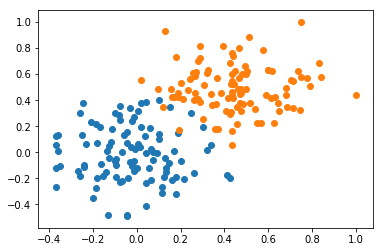

In [44]:
plt.scatter(data[:100,0],data[:100,1])
plt.scatter(data[100:,0],data[100:,1])

In [46]:
x_train, x_test, y_train, y_test = train_test_split(data, label, test_size=0.4, random_state=42)

In [47]:
v,data_frame = LpMinimizeClassification(x_train,y_train)

0
100
begin solve
time: 0.15259408950805664
Status: Unbounded


In [48]:
data_frame

t          v          e
0      0.00000    0.00000 -16.209815
1      0.00000    0.00000 -74.261223
2      0.00000    0.00000 -35.520319
3      0.00000    0.00000 -48.577536
4      0.00000    0.00000 -24.959992
5      0.00000    0.00000 -22.965776
6      0.00000    0.00000 -34.348822
7      0.00000    0.00000 -66.146677
8      0.00000    0.00000 -12.296771
9      0.00000    0.00000 -40.016252
10     0.00000    0.00000 -56.690272
11     0.00000    0.00000 -36.467601
12     0.00000    0.00000 -18.529344
13     0.00000    0.00000 -75.003968
14     0.00000    0.00000 -49.275363
15     0.00000    0.00000 -31.941461
16     0.00000    0.00000 -22.689746
17     0.00000    0.00000 -27.792026
18     0.00000    0.00000 -59.903486
19     0.00000    0.00000 -23.157274
20     0.00000    0.00000 -41.436727
21     0.00000    0.00000 -40.112083
22     0.00000    0.00000 -30.114162
23     0.00000    0.00000 -39.934902
24     0.00000    0.00000   0.000000
25     0.00000    0.00000 -23.375207
26     0.00000    0.00000 -48.132932
27   359.10673  359.10673 -34.082084
28     0.00000    0.00000 -22.006941
29     0.00000    0.00000 -44.177660
..         ...        ...        ...
91     0.00000    0.00000 -45.324607
92     0.00000    0.00000 -69.435752
93     0.00000    0.00000 -35.895038
94     0.00000    0.00000 -20.050077
95     0.00000    0.00000 -33.201068
96     0.00000    0.00000 -12.913470
97     0.00000    0.00000 -59.747325
98     0.00000    0.00000 -43.703766
99     0.00000    0.00000 -22.420387
100    0.00000    0.00000 -24.843208
101    0.00000    0.00000 -48.829534
102    0.00000    0.00000 -47.831064
103    0.00000    0.00000 -43.975550
104    0.00000    0.00000 -27.063320
105    0.00000    0.00000 -22.878663
106    0.00000    0.00000  -6.138057
107    0.00000    0.00000 -36.393140
108    0.00000    0.00000 -77.908967
109    0.00000    0.00000 -32.445295
110    0.00000    0.00000 -33.691030
111    0.00000    0.00000  -3.232022
112    0.00000    0.00000 -33.911176
113    0.00000    0.00000 -43.987151
114    0.00000    0.00000 -19.573771
115    0.00000    0.00000 -40.717703
116    0.00000    0.00000 -84.554243
117    0.00000    0.00000 -43.264800
118    0.00000    0.00000 -30.414767
119    0.00000    0.00000 -27.510014
120    0.00000  472.56538   0.000000

[121 rows x 3 columns]

### number of V = 0

In [49]:
len(v)- np.count_nonzero(v)

118

### Total number of V

In [50]:
len(v)

121

### accuracy on train data

In [51]:
calculate_accuracy(x_train,y_train,x_train,v)

100.0

### accuracy on test data

In [52]:
calculate_accuracy(x_test,y_test,x_train,v)

93.75